In [2]:
# bootstrap (put this cell first in all notebooks)
import os, sys
PROJECT_ROOT = r"C:\Users\31624\Documents\MIT\Programming\FreqTransfer"
os.chdir(PROJECT_ROOT)
if PROJECT_ROOT not in sys.path: sys.path.insert(0, PROJECT_ROOT)
print("Python:", sys.executable); print("CWD:", os.getcwd())


Python: c:\Users\31624\Documents\MIT\Programming\FreqTransfer\.venv\Scripts\python.exe
CWD: C:\Users\31624\Documents\MIT\Programming\FreqTransfer


Converged: True


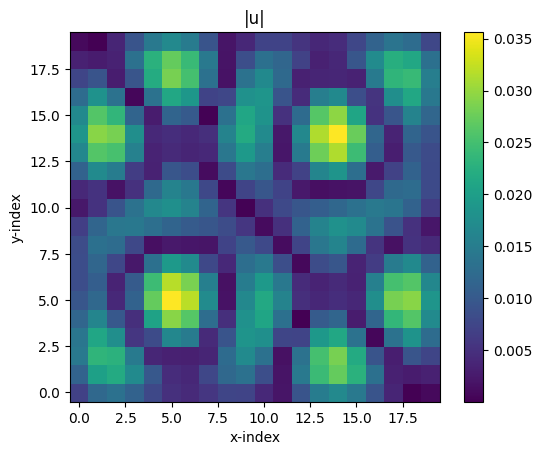

In [3]:
from src import GridSpec, assemble_operator, RandomPointSource, build_load, direct_solve, plot_field
g = GridSpec(2, (20,20), (1.0,1.0))
A = assemble_operator(g, k=15.0, kind="helmholtz")
b = build_load(RandomPointSource(seed=0), g)
res = direct_solve(A, b)
print("Converged:", res.converged)
_ = plot_field(res.solution, g.shape, "magnitude")


# 01 — Basics: grids • loads • operators • solvers • plots

This primer shows the minimal building blocks used across the project.

- Grid & spacing
- Loads (point, plane, random)
- Operators (Laplacian, Helmholtz; optional PML)
- Solvers (direct vs. GMRES)
- Quick plots: |u|, Re, Im, phase


In [4]:
from src import (
    GridSpec, FDConfig, PMLConfig, SolverOptions,
    PointSource, PlaneWave, RandomPointSource, build_load,
    laplacian_operator, helmholtz_operator, assemble_operator,
    gmres_solve, direct_solve,
    plot_field, plot_residuals,
)
import numpy as np


## Grid & spacing

We use `GridSpec(dims, shape, lengths)`. Spacing is derived:
Δx = L/(n−1) per axis.


In [5]:
g = GridSpec(dims=2, shape=(40, 40), lengths=(1.0, 1.0))
print("shape:", g.shape, "lengths:", g.lengths, "spacing:", g.spacing, "N:", g.N)


shape: (40, 40) lengths: (1.0, 1.0) spacing: (0.02564102564102564, 0.02564102564102564) N: 1600


## Loads (RHS)

- **PointSource(location, amplitude, phase, sigma_h)** — optional Gaussian spread.
- **PlaneWave(kvec, amplitude, phase)**
- **RandomPointSource(seed, amp_range, phase_range)**


In [7]:
b_point  = build_load(PointSource(location=(0.5, 0.5)), g)
b_plane  = build_load(PlaneWave(kvec=(20.0, 0.0)), g)
b_random = build_load(RandomPointSource(seed=42), g)

print(b_point.shape, b_plane.shape, b_random.shape)  # all (N,)


(1600,) (1600,) (1600,)


## Operators

- **Laplacian:** `laplacian_operator(g, fd)`
- **Helmholtz:** `helmholtz_operator(g, k, fd, pml=None, m=None)`
- High-level wrapper: `assemble_operator(g, k, kind="helmholtz", ...)`


In [8]:
k = 25.0
A = assemble_operator(grid=g, k=k, kind="helmholtz")  # no PML
A


<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 7840 stored elements and shape (1600, 1600)>

## Solvers

- **Direct (LU):** fast for small/medium problems, reference quality.
- **GMRES:** iterative; useful for larger systems and to study convergence.


Direct: converged | info: 0


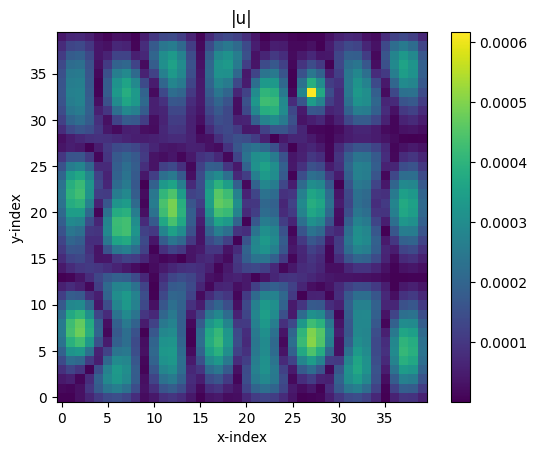

In [9]:
res_dir = direct_solve(A, b_random)
print("Direct:", "converged" if res_dir.converged else "failed", "| info:", res_dir.info)

_ = plot_field(res_dir.solution, shape=g.shape, which="magnitude")


GMRES: converged | iters: 1392


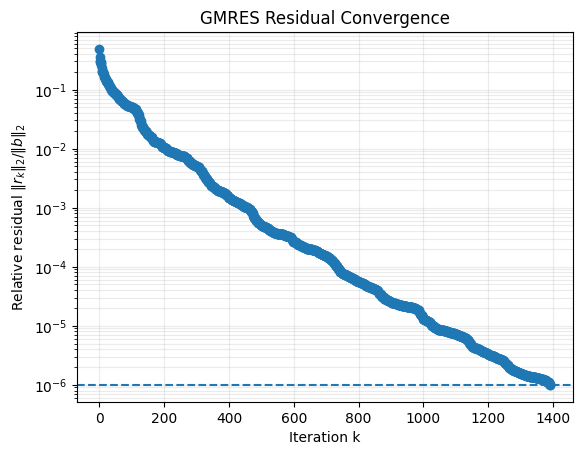

In [10]:
opts = SolverOptions(tol=1e-6, restart=200)
res_it = gmres_solve(A, b_point, options=opts)
print("GMRES:", "converged" if res_it.converged else "failed", 
      "| iters:", len(res_it.residuals))

_ = plot_residuals(res_it, tol=opts.tol)


## Visualizing the field
We often view **magnitude** and **phase**; **real**/**imag** can help debug symmetry.


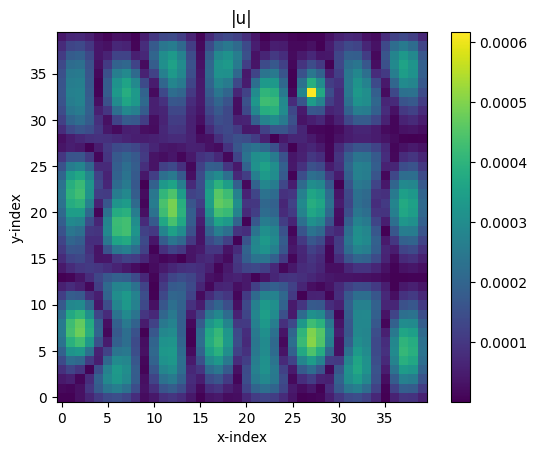

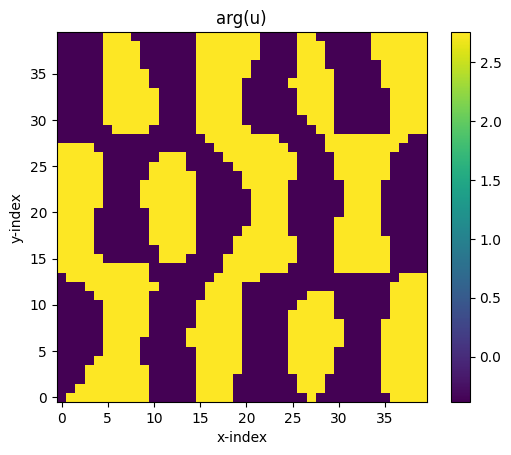

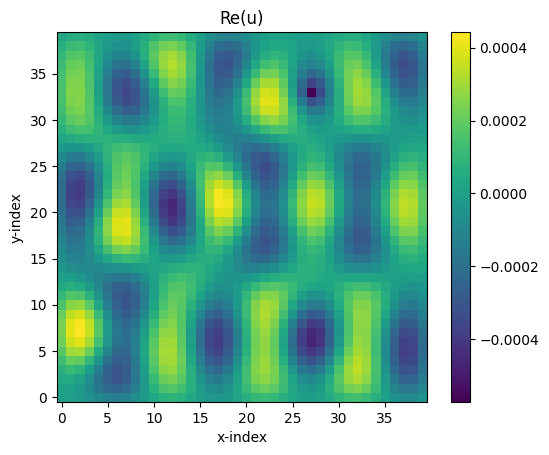

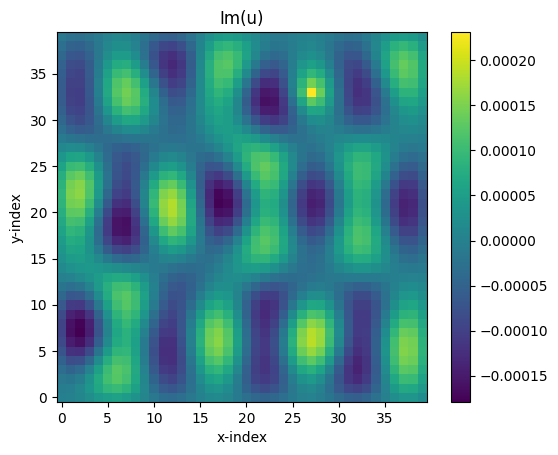

In [11]:
u = res_dir.solution  # from the direct solve above

_ = plot_field(u, g.shape, which="magnitude")
_ = plot_field(u, g.shape, which="phase")
_ = plot_field(u, g.shape, which="real")
_ = plot_field(u, g.shape, which="imag")


## Optional: PML

Turn on a simple absorbing boundary and compare visually.


Direct+PML: True


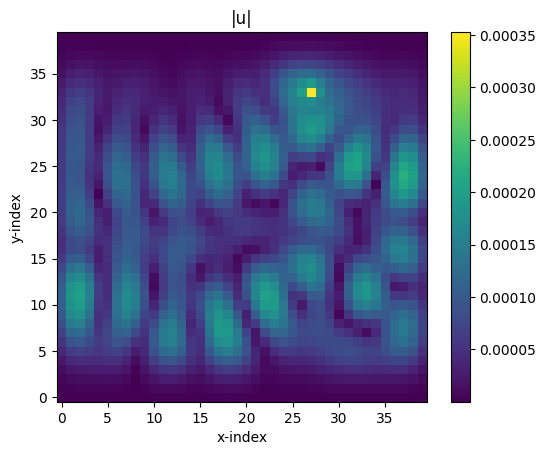

In [12]:
pml = PMLConfig(thickness=8, m=3, sigma_max=50.0)
A_pml = assemble_operator(grid=g, k=k, kind="helmholtz", pml=pml)

res_pml = direct_solve(A_pml, b_random)
print("Direct+PML:", res_pml.converged)

_ = plot_field(res_pml.solution, g.shape, which="magnitude")


### Recap

- `GridSpec` fully defines the domain; spacing & N are derived.
- `build_load(...)` returns a **flattened complex** RHS of size N.
- `assemble_operator(...)` builds Laplacian/Helmholtz matrices.
- `direct_solve` is a good default for small demos; `gmres_solve` for convergence studies.
- Use `plot_field` and `plot_residuals` for consistent visuals.
